# The Problem
The goal is to solve the following ordinary differential equation (ODE) with differentiable quantum circuits (DQC's);
$$
\frac{d u}{d x}+\lambda u(\kappa+\tan (\lambda x))=0, \quad u(0)=u_{0}
$$
The solution of this is known to be a *damped oscillating function*;
$$
u(x)=\exp (-\kappa \lambda x) \cos (\lambda x)+c o n s t
$$


**Reference paper** - Kyriienko, Oleksandr, Annie E. Paine, and Vincent E. Elfving. "Solving nonlinear differential equations with differentiable quantum circuits." Physical Review A 103.5 (2021): 052416

# The Solution
Initially, the following equation is input;
$$
\begin{array}{ll}\text { differential equations } & \begin{array}{l}\mathrm{d} \mathrm{u}_{1} / \mathrm{dx}=\lambda_{1} \mathrm{u}_{2}+\lambda_{2} \mathrm{u}_{1} \\ \mathrm{~d} \mathrm{u}_{2} / \mathrm{dx}=-\lambda_{2} \mathrm{u}_{2}-\lambda_{1} \mathrm{u}_{1}\end{array} \\ \text { boundary conditions } & \mathrm{u}_{1}(0)=\mathrm{u}_{1,0}, \mathrm{u}_{2}(0)=\mathrm{u}_{2,0}\end{array}
$$


In [ ]:
pip install qiskit

In [ ]:
pip install qiskit[visualization]

In [ ]:
pip install qiskit-ibm-runtime

In [ ]:
pip install qiskit-machine-learning

# Ingredients


*   **Feature Map** - Product
*   **Variational Ansatz** - EfficientSU2, a hardware-efficient circuit that consists of layers of single-qubit operations spanning SU(2) and CX entanglements.
*   **Cost Function** - qubit magnetization, that is the expectation value $\left\langle\hat{Z}_{j}\right\rangle$.
*   **Loss Function** - MSE

# The Implementation of the Solution


# Adding the Product Feature Map

In the reference paper it is stated that a *product feature space* is expressed as;
$$
\hat{\mathcal{U}}_{\varphi}(x)=\bigotimes_{j=1}^{N} \exp \left(-i \frac{\arcsin x}{2} \hat{Y}_{j}\right)
$$
The definition of the Pauli_Feature_Map in the Qiskit library is as follows;
$$
U_{\Phi(\vec{x})}=\exp \left(i \sum_{S \in \mathcal{I}} \phi_{S}(\vec{x}) \prod_{i \in S} P_{i}\right)
$$ where $$
P_{i} \in\{I, X, Y, Z\}
$$
Therefore, once we have selected $Y_i$ as the Pauli operator, it can be surmised that;
$$
\phi(\vec{x}) = -\frac{\arcsin x}{2}
$$
and this will be expressed as the *alpha* parameter of the PauliFeatureMap.

In [21]:
from qiskit.circuit.library import PauliFeatureMap
from qiskit import QuantumCircuit
import numpy as np

num_of_qubits = 8

x = 0.3                       # this should be a vector and subsequent code must receive it as such

pauli_rotation_factor = (-(np.arcsin(x))/2)
prep = PauliFeatureMap(num_of_qubits, alpha=pauli_rotation_factor, reps=1, paulis=['Y'])

print(prep.decompose().draw())


     ┌───┐┌─────────┐┌────────────────────────────┐┌──────────┐
q_0: ┤ H ├┤ Rx(π/2) ├┤ P(-0.152346327007699*x[0]) ├┤ Rx(-π/2) ├
     ├───┤├─────────┤├────────────────────────────┤├──────────┤
q_1: ┤ H ├┤ Rx(π/2) ├┤ P(-0.152346327007699*x[1]) ├┤ Rx(-π/2) ├
     ├───┤├─────────┤├────────────────────────────┤├──────────┤
q_2: ┤ H ├┤ Rx(π/2) ├┤ P(-0.152346327007699*x[2]) ├┤ Rx(-π/2) ├
     ├───┤├─────────┤├────────────────────────────┤├──────────┤
q_3: ┤ H ├┤ Rx(π/2) ├┤ P(-0.152346327007699*x[3]) ├┤ Rx(-π/2) ├
     ├───┤├─────────┤├────────────────────────────┤├──────────┤
q_4: ┤ H ├┤ Rx(π/2) ├┤ P(-0.152346327007699*x[4]) ├┤ Rx(-π/2) ├
     ├───┤├─────────┤├────────────────────────────┤├──────────┤
q_5: ┤ H ├┤ Rx(π/2) ├┤ P(-0.152346327007699*x[5]) ├┤ Rx(-π/2) ├
     ├───┤├─────────┤├────────────────────────────┤├──────────┤
q_6: ┤ H ├┤ Rx(π/2) ├┤ P(-0.152346327007699*x[6]) ├┤ Rx(-π/2) ├
     ├───┤├─────────┤├────────────────────────────┤├──────────┤
q_7: ┤ H ├┤ Rx(π/2) ├┤ P(-0.152346327007

# Differentiating the quantum feature map
$$
\begin{aligned} \frac{d}{d x} \hat{\mathcal{U}}_{\varphi}(x)= & \frac{1}{2}\left(\frac{d}{d x} \varphi(x)\right) \sum_{j^{\prime}=1}^{N} \bigotimes_{j=1}^{N}\left(-i \hat{Y}_{j^{\prime}} \delta_{j, j^{\prime}}\right) \hat{R}_{y, j}(\varphi[x]) \\ & =\frac{1}{2}\left(\frac{d}{d x} \varphi(x)\right) \sum_{j^{\prime}=1}^{N} \bigotimes_{j=1}^{N} \hat{R}_{y, j}\left(\varphi[x]+\pi \delta_{j, j^{\prime}}\right)\end{aligned}
$$
which can be simplified to
$$
\frac{d}{d x}\left\langle\emptyset\left|\hat{\mathcal{U}}_{\varphi}(x)^{\dagger} \hat{\mathcal{C}} \hat{\mathcal{U}}_{\varphi}(x)\right| \emptyset\right\rangle=\frac{1}{4}\left(\frac{d}{d x} \varphi(x)\right)\left(\langle\hat{C}\rangle^{+}-\langle\hat{C}\rangle^{-}\right)
$$

# Adding the EfficientSU(2) Variational Ansatz

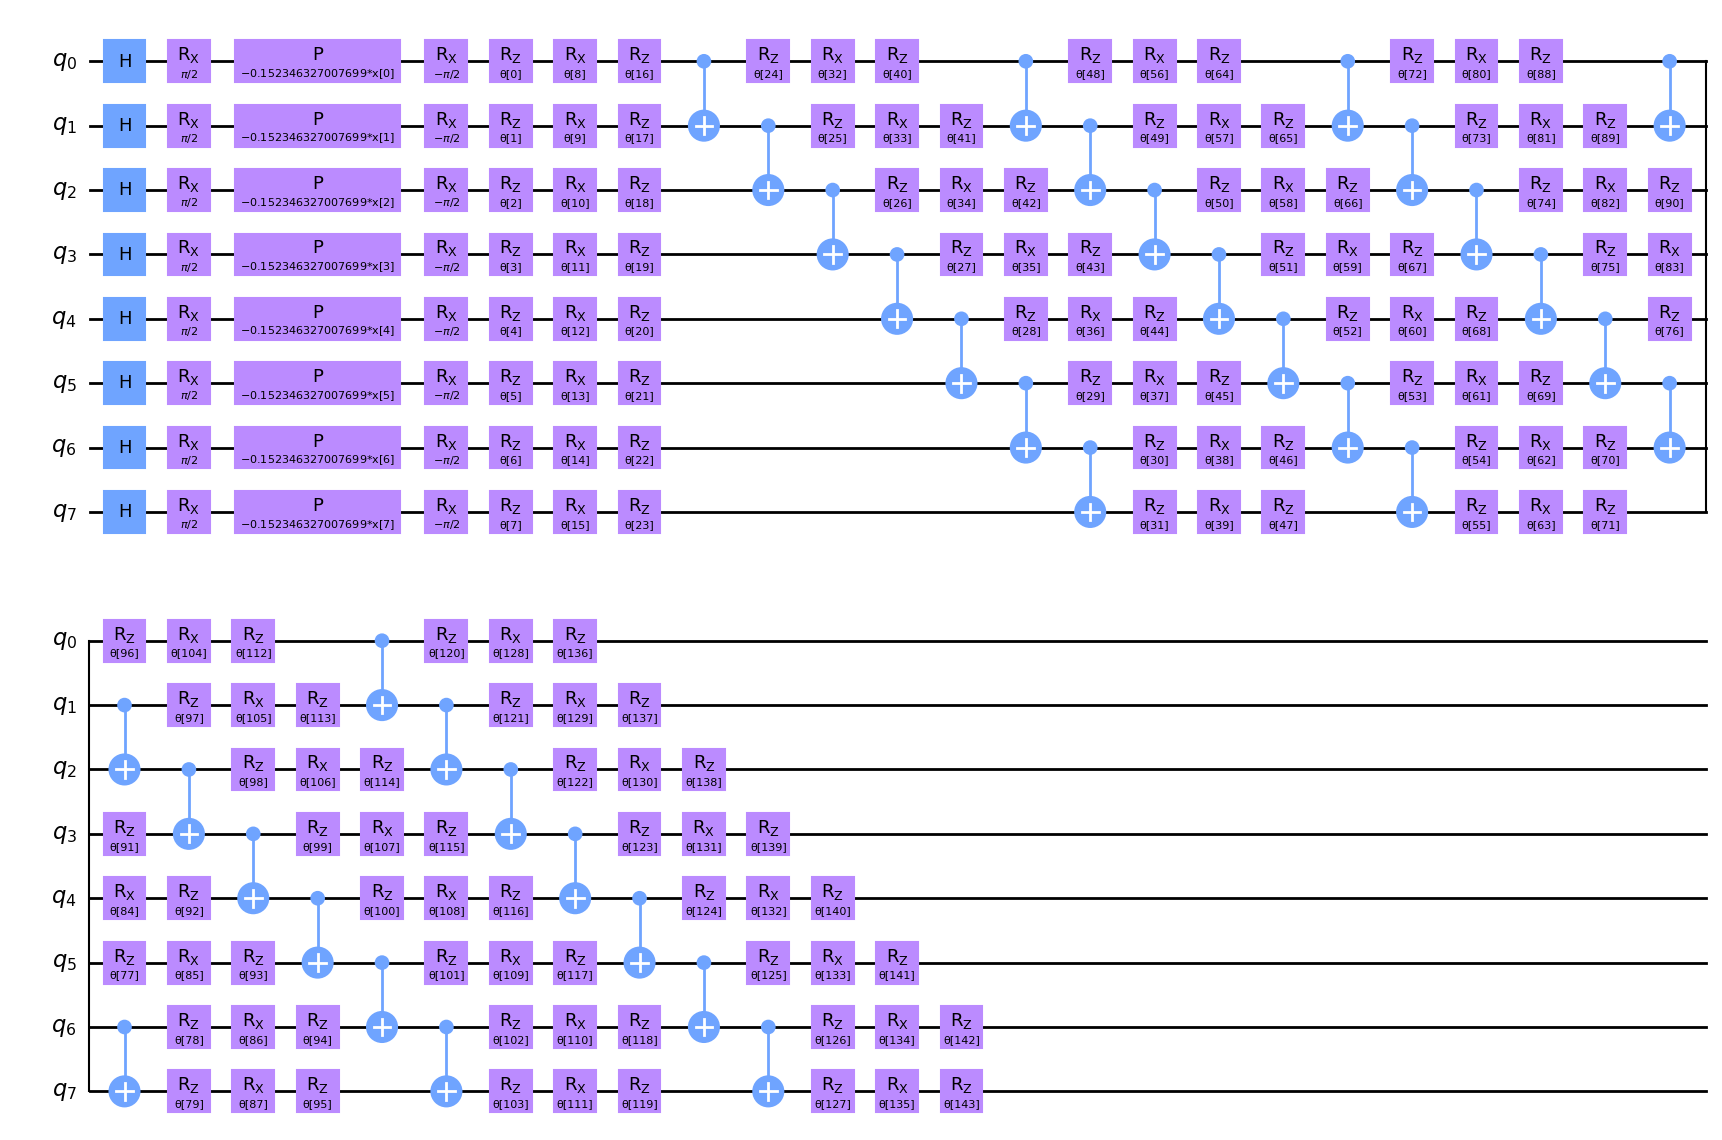

In [22]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(8, su2_gates=["rz", "rx", "rz"], entanglement="linear", reps=5)
ansatz = prep.compose(ansatz)
ansatz.decompose().draw("mpl")


# Adding the Qubit Magnetisation Cost Function

In [16]:
from qiskit.quantum_info import SparsePauliOp

observable_1 = SparsePauliOp.from_list([("Z", 1)])

In [18]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session


service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.get_backend("ibmq_qasm_simulator")

session = Session(backend=backend)

estimator = Estimator(session=session)
sampler = Sampler(session=session)

In [19]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session

def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [ ]:
# SciPy minimizer routine
from scipy.optimize import minimize
import time

start_time = time.time()

x0 = np.ones(40)
result = minimize(cost_func_vqe, x0, args=(ansatz, observable_1, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time

In [ ]:
result